### Exploratory Data Analysis with Python

We will explore the NYC MTA turnstile data set. These data files are from the New York Subway. It tracks the hourly entries and exits to turnstiles (UNIT) by day in the subway system.

Here is an [example of what you could do with the data](https://jameskao.me/analyzing-the-nyc-subway-dataset/). James Kao investigates how subway ridership is affected by incidence of rain.

## Exercise 1

- Download a few [MTA turnstile data files](http://web.mta.info/developers/turnstile.html)
- Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row. For example, one key-value pair should look like


        {    ('A002','R051','02-00-00','LEXINGTON AVE'):    
             [
               ['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'],          
                 ['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'],  
                ['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'],
              ...   
         ] 
        }


In [2]:
%matplotlib inline
import csv
import collections
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import sqlite3

files = ['turnstile_170107.txt','turnstile_170114.txt','turnstile_170121.txt',\
         'turnstile_170128.txt','turnstile_170204.txt']
#'turnstile_160305.txt'


sqlite_file = 'mta_turnstile.sqlite'


In [3]:
data = []
for file in files:
    with open(file,'r') as f:
        reader = csv.reader(f)
        next(reader, None) # skip the header
        if len(data) == 0:
            data = list(reader)
        else:
            data = data + list(reader)

print (len(data))
print (data[:5])

971745
[['A002', 'R051', '02-00-00', '59 ST', 'NQR456W', 'BMT', '12/31/2016', '03:00:00', 'REGULAR', '0005991546', '0002028378                                            '], ['A002', 'R051', '02-00-00', '59 ST', 'NQR456W', 'BMT', '12/31/2016', '07:00:00', 'REGULAR', '0005991565', '0002028389                                            '], ['A002', 'R051', '02-00-00', '59 ST', 'NQR456W', 'BMT', '12/31/2016', '11:00:00', 'REGULAR', '0005991644', '0002028441                                            '], ['A002', 'R051', '02-00-00', '59 ST', 'NQR456W', 'BMT', '12/31/2016', '15:00:00', 'REGULAR', '0005991971', '0002028502                                            '], ['A002', 'R051', '02-00-00', '59 ST', 'NQR456W', 'BMT', '12/31/2016', '19:00:00', 'REGULAR', '0005992418', '0002028543                                            ']]


In [4]:
data_dict = collections.defaultdict(list)
distribution = collections.Counter()

for row in data:
    data_dict[tuple(row[:4])].append(row[4:-1] + [row[-1].strip()])

for k,v in data_dict.items():
    distribution[len(v)] += 1

print ('\nData dictionary length: '+ str(len(data_dict)))
print ('\nDistribution:')
print (distribution)



Data dictionary length: 4631

Distribution:
Counter({210: 1390, 211: 1070, 212: 580, 209: 308, 213: 307, 200: 163, 215: 153, 214: 152, 216: 120, 208: 66, 199: 35, 207: 31, 205: 29, 201: 23, 218: 22, 221: 20, 202: 11, 206: 11, 203: 10, 223: 9, 191: 8, 217: 8, 219: 8, 195: 7, 197: 7, 198: 7, 225: 7, 192: 6, 204: 5, 224: 5, 189: 4, 170: 3, 51: 3, 181: 3, 183: 3, 190: 3, 226: 3, 1: 2, 145: 2, 179: 2, 196: 2, 220: 2, 161: 2, 133: 1, 6: 1, 7: 1, 137: 1, 143: 1, 23: 1, 158: 1, 48: 1, 169: 1, 171: 1, 173: 1, 174: 1, 175: 1, 176: 1, 52: 1, 184: 1, 180: 1, 194: 1, 111: 1})


In [ ]:
## USING SQLITE
## 1. Create tables 

conn = sqlite3.connect(sqlite_file)
c = conn.cursor()
c.execute('drop table if exists turnstile')
c.execute('create table turnstile ( \
    filename text,\
    file_linenum integer,\
    ca text comment "control area",\
    unit text,\
    scp text comment "subunit channel position",\
    station text,\
    linename text,\
    division text,\
    datetime timestamp,\
    desc text,\
    cum_entries integer comment "cummulative entries as is",\
    cum_exits integer comment "cummulative exits as is")')
conn.commit()

c.execute('SELECT type, count(*) FROM sqlite_master group by type')
all_rows = c.fetchall()
print(all_rows)
conn.close()


In [ ]:
## 2. Load data

conn = sqlite3.connect(sqlite_file)
c = conn.cursor()
counter = 0

for file in files:
    print (file)
    with open(file,'r') as f: 
        reader = csv.reader(f)
        next(reader, None) # skip the header
        to_db = [\
            (file, reader.line_num, row[0], row[1], row[2], row[3], row[4], row[5], \
             datetime.strptime(row[6]+' '+row[7], '%m/%d/%Y %H:%M:%S'), \
             row[8], row[9], row[10].strip()) for row in reader]
        
        try:
            c.executemany('INSERT INTO turnstile VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);', to_db)
            conn.commit()
        except sqlite3.Error as e:
            conn.rollback()
            print('Can\'t insert %s...' % (file))
            print(e)

print ('done...')
conn.close()

## Exercise 2
- Let's turn this into a time series.

 For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the cumulative count of entries.

This basically means keeping only the date, time, and entries fields in each list. You can convert the date and time into datetime objects -- That is a python class that represents a point in time. You can combine the date and time fields into a string and use the [dateutil](https://dateutil.readthedocs.io/en/stable/) module to convert it into a datetime object.

Your new dict should look something like
 
    {    ('A002','R051','02-00-00','LEXINGTON AVE'):    
             [
                [datetime.datetime(2013, 3, 2, 3, 0), 3788],
                [datetime.datetime(2013, 3, 2, 7, 0), 2585],
                [datetime.datetime(2013, 3, 2, 12, 0), 10653],
                [datetime.datetime(2013, 3, 2, 17, 0), 11016],
                [datetime.datetime(2013, 3, 2, 23, 0), 10666],
                [datetime.datetime(2013, 3, 3, 3, 0), 10814],
                [datetime.datetime(2013, 3, 3, 7, 0), 10229],
                ...
              ],
     ....
     }



In [36]:
def to_time_series (source_dict):
    
    time_series = {}
    discarded = {}
    discarded_counts = collections.Counter()
      
    for k, v in source_dict.items():
        
        time_series[k] = []
        bad_days = []
        v_list = sorted(v, key=lambda x: datetime.strptime(x[2] + ' ' + x[3], '%m/%d/%Y %H:%M:%S'))
        
        for i, row in enumerate(v_list):
            
            if i == 0 or row[2]!= last_date:
                last_date, last_entry, last_exit = row[2], int(row[5]), int(row[6])
            else:  
                if int(row[5]) - last_entry > 10000 or int(row[5]) - last_entry < 0:
                    last_entry = int(row[5])
                    bad_days.append(row[2])
                if int(row[6]) - last_exit > 10000 or int(row[6]) - last_exit < 0:
                    last_exit = int(row[6])
                    bad_days.append(row[2])
                
            time_series[k].append([
                    datetime.strptime(row[2] + ' ' + row[3], '%m/%d/%Y %H:%M:%S'), 
                    int(row[5]) - last_entry, 
                    int(row[6]) - last_exit])
            
            last_date, last_entry, last_exit = row[2], int(row[5]), int(row[6])
            
        if len(bad_days) > 0:
            discarded[k] = []
            for row in v_list:
                if row[2] in bad_days:
                    discarded[k].append([row[2],row[3],row[5],row[6]])
            discarded_counts[len(discarded[k])] += 1
        
    return time_series, discarded, discarded_counts

time_series_data, discarded_data, discarded_data_counts = to_time_series(data_dict)

print (len(time_series_data))
print (len(discarded_data))
print (discarded_data_counts)

4631
113
Counter({6: 25, 211: 14, 7: 12, 210: 10, 8: 6, 4: 5, 5: 5, 209: 4, 213: 4, 18: 3, 212: 3, 19: 2, 224: 2, 2: 1, 10: 1, 11: 1, 12: 1, 205: 1, 14: 1, 79: 1, 16: 1, 206: 1, 22: 1, 215: 1, 207: 1, 30: 1, 225: 1, 214: 1, 183: 1, 138: 1, 85: 1})


In [16]:
# Data Behaviour:
# 1. Cummulative counts switch and continue on (whether it switches to higher, or lower number)
# 2. Cummulative counts switches, and switches back (examples below)
# 3. Cummulative counts decrease. Based on counter above roughly 44 
#    (i.e ones that have more than 150 records discarded) out of 4631 keys will have most of the 
#    point in time counts = 0
#
#('R504', 'R276', '00-00-01', 'VERNON-JACKSON')
#[['01/11/2017', '03:00:00', '0008379235', '0001379106'], 
# ['01/11/2017', '07:00:00', '0008379344', '0001379120'], 
# ['01/11/2017', '11:00:00', '0008380750', '0001510337'], <== HERE
# ['01/11/2017', '15:00:00', '0008381050', '0001379330'], 
# ['01/11/2017', '19:00:00', '0008381548', '0001379445']]
#('PTH12', 'R542', '00-00-00', 'TWENTY THIRD ST')
#[['01/21/2017', '06:18:57', '0000055828', '0000001627'], 
# ['01/21/2017', '10:30:57', '0000055834', '0000001628'], 
# ['01/21/2017', '12:26:17', '0001618332', '0000146701'], <== HERE
# ['01/21/2017', '14:42:57', '0000055840', '0000001629'], 
# ['01/21/2017', '18:54:57', '0000055872', '0000001635']]
#('R158', 'R084', '00-06-00', '59 ST COLUMBUS')
#[['01/31/2017', '03:00:00', '0001262161', '0000280489'], 
# ['01/31/2017', '03:00:00', '0001262161', '0013977513'], <== HERE, note the same timestamp
# ['01/31/2017', '07:00:00', '0001262163', '0000280542'], 
# ['01/31/2017', '11:00:00', '0001262205', '0000280929']]
#('PTH17', 'R541', '01-00-00', 'THIRTY THIRD ST')
#[['01/03/2017', '12:43:56', '0000000003', '0000416540'], 
# ['01/03/2017', '16:55:56', '0000000003', '0000416540'], 
# ['01/03/2017', '20:14:01', '0001965234', '0001229284'], <== HERE
# ['01/03/2017', '21:07:56', '0000000003', '0000416540']]
#
#('C019', 'R232', '00-00-02', '45 ST') [ !!! this whole thing counts backwards...]


## Exercise 3
- These counts are cumulative every n hours. We want total daily entries. 

Now make it that we again have the same keys, but now we have a single value for a single day, which is not cumulative counts but the total number of passengers that entered through this turnstile on this day.


In [265]:
def to_daily (source_dict):
    daily = {}
    distribution = collections.Counter()

    for k, v in source_dict.items():
        output = {}
        for row in v:
            if row[0].date() not in output:
                output[row[0].date()] = [0,0]
            output[row[0].date()][0] += row[1]
            output[row[0].date()][1] += row[2]
    
        daily[k] = list([x[0], x[1][0], x[1][1]] for x in list(output.items()))
        distribution[len(list([x[0], x[1][0], x[1][1]] for x in list(output.items())))] += 1
        output.clear()
        
    return daily, distribution

daily_data, daily_dist_data = to_daily(time_series_data)

print (len(daily_data))
print (distribution_daily)


4631
Counter({7: 4534, 5: 33, 4: 9, 1: 7, 6: 2, 2: 1, 3: 1})


## Exercise 4
- We will plot the daily time series for a turnstile.

In ipython notebook, add this to the beginning of your next cell:    

    %matplotlib inline

This will make your matplotlib graphs integrate nicely with the notebook.
To plot the time series, import matplotlib with 

    import matplotlib.pyplot as plt

Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists:
dates and counts. This should plot it:

    plt.figure(figsize=(10,3))
    plt.plot(dates,counts)


In [266]:
daily_counts = collections.Counter()

for i in [item for sublist in list(daily_data.values()) for item in sublist]:
    daily_counts[i[0]] += i[1]

print ('done...')

done...


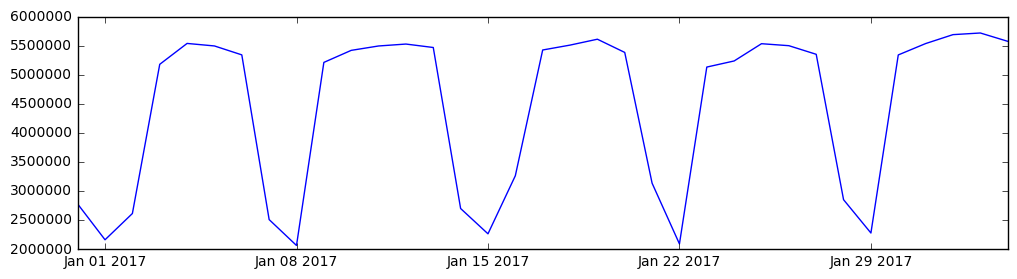

In [267]:
plt.figure(figsize=(12,3))
plt.plot(
    sorted(list(daily_counts.keys())), 
    [daily_counts[x] for x in sorted(list(daily_counts.keys()))])


## Exercise 5
- So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.


In [268]:
## USING pandas

flatten_time_series_data = []
for k, v in time_series_data.items():
    for item in list(v):
        flatten_time_series_data.append(list(k) + item)

df = pd.DataFrame(flatten_time_series_data, 
                  columns=['C/A', 'UNIT', 'SCP', 'STATION', 'DATETIME','ENTRIES','EXITS'])

flatten_time_series_data = []
df.head()


,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES,EXITS
0,R311,R053,00-00-00,3 AV-149 ST,2016-12-31 03:00:00,0,0
1,R311,R053,00-00-00,3 AV-149 ST,2016-12-31 07:00:00,16,32
2,R311,R053,00-00-00,3 AV-149 ST,2016-12-31 11:00:00,120,143
3,R311,R053,00-00-00,3 AV-149 ST,2016-12-31 15:00:00,219,156
4,R311,R053,00-00-00,3 AV-149 ST,2016-12-31 19:00:00,313,214


In [359]:
group_1 = df.groupby(['C/A','UNIT','STATION', pd.Grouper(freq='D',key='DATETIME')]).sum()
len(group_1)
group_1.head()

ENTRIES  EXITS
C/A  UNIT STATION DATETIME                  
A002 R051 59 ST   2016-12-31     7509   3769
                  2017-01-01     5990   3327
                  2017-01-02     7685   4699
                  2017-01-03    14746   9545
                  2017-01-04    15162   9855

## Exercise 6
- Similarly, combine everything in each station, and come up with a time series of `[(date1, count1),(date2,count2),...]` type of time series for each STATION, by adding up all the turnstiles in a station.

In [360]:
group_2 = df.groupby(['STATION', pd.Grouper(freq='D',key='DATETIME')]).sum().reset_index()
print (len(group_2))
group_2.head()

13016


,STATION,DATETIME,ENTRIES,EXITS
0,1 AV,2016-12-31,13745,16252
1,1 AV,2017-01-01,9732,10897
2,1 AV,2017-01-02,11171,13129
3,1 AV,2017-01-03,20162,22394
4,1 AV,2017-01-04,21119,22574


## Exercise 7
- Plot the time series for a station

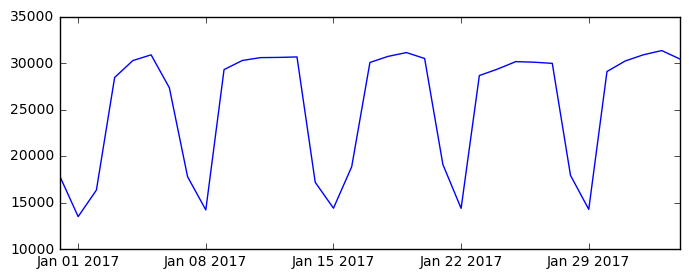

In [361]:
plt.figure(figsize=(8,3))
plt.plot(
    group_2.loc[group_2['STATION'] == '103 ST']['DATETIME'], 
    group_2.loc[group_2['STATION'] == '103 ST']['ENTRIES'])

## Exercise 8
- Make one list of counts for **one** week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts.
Make the same list for another week, and another week, and another week.
`plt.plot(week_count_list)` for every `week_count_list` you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.



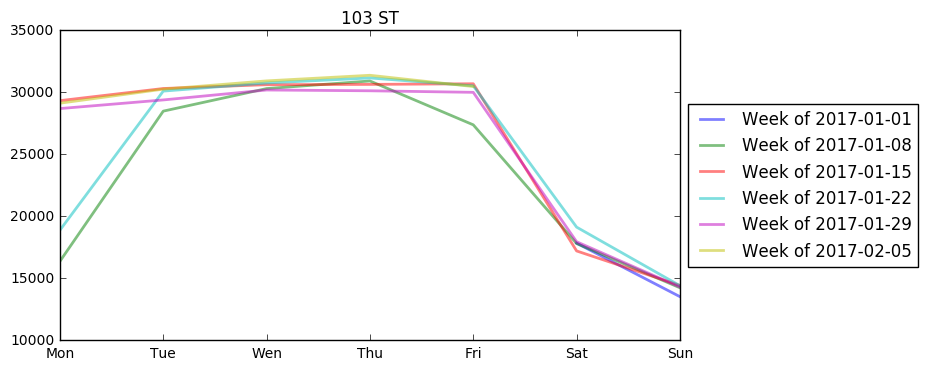

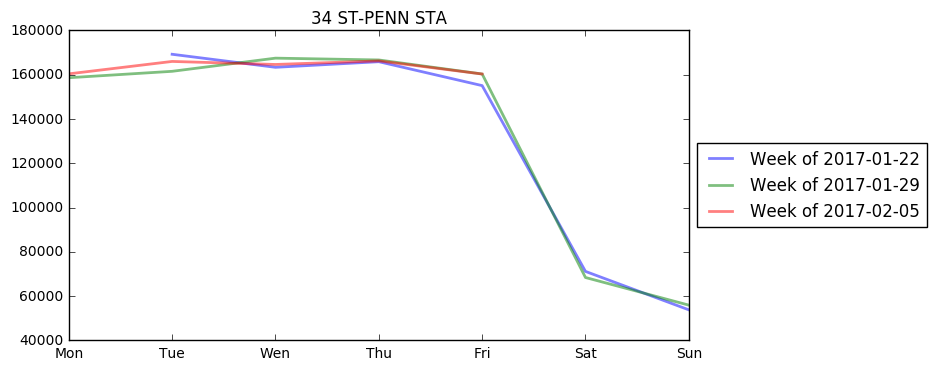

In [416]:
def weekday_breakdown(df, station_name, start_date = None, end_date = None):

    df_weekday = df
    pred_start = True
    pred_end = True
    
    if start_date != None:
        pred_start = df_weekday['DATETIME'] >= datetime.strptime(start_date, '%Y-%m-%d')
        
    if end_date != None:
        pred_end = df_weekday['DATETIME'] <= datetime.strptime(end_date, '%Y-%m-%d')
        
    pred_station = df_weekday['STATION'] == station_name
    
    df_weekday = df_weekday[(pred_station) & (pred_start) & (pred_end)][['DATETIME','ENTRIES','EXITS']]
    df_weekday = df_weekday.groupby([pd.Grouper(freq='W',key='DATETIME')])
    
    fig = plt.figure(figsize=(8,4))
    ax = plt.subplot(111)
    
    for name, group in df_weekday:
        
        wholeweek = [1,2,3,4,5,6,7]
        weekdays = list(group['DATETIME'].apply(lambda x: x.isoweekday()))
        entries = list(group['ENTRIES'])

        for day in weekdays:
            wholeweek.remove(day)
        for day in wholeweek:
            weekdays.insert(day-1, day)
            entries.insert(day-1, None)
        
        wkl = ax.plot(
            weekdays, 
            [None if x==None else x for x in entries], 
            label = 'Week of {:%Y-%m-%d}'.format(name),
            linewidth=2.0,
            alpha = .5
        )
        ax.set_xticklabels(['Mon','Tue','Wen','Thu','Fri','Sat','Sun'])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.title(station_name)
    del df_weekday

weekday_breakdown(group_2, '103 ST')
weekday_breakdown(group_2, '34 ST-PENN STA', start_date='2017-01-17')


## Exercise 9
- Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [379]:
def rideship_by_timerange (df, start_date = None, end_date = None):
    grp = df
    
    if start_date != None:
        pred_start = grp['DATETIME'] >= datetime.strptime(start_date, '%Y-%m-%d')
        grp = grp[pred_start]
        
    if end_date != None:
        pred_end = (grp['DATETIME'] <= datetime.strptime(end_date, '%Y-%m-%d'))
        grp = grp[pred_end]

    grp['RIDESHIP'] = grp['ENTRIES'] + grp ['EXITS']
    grp = grp.groupby(['STATION']).sum()
    
    return grp

def get_busiest (df):
    return df.sort_values(by=['RIDESHIP'], ascending = False).ix[0]


rideship_1 = rideship_by_timerange(group_2)
rideship_2 = rideship_by_timerange(group_2, start_date='2017-01-10')
rideship_3 = rideship_by_timerange(group_2, end_date='2017-01-10')
rideship_4 = rideship_by_timerange(group_2, start_date='2017-01-10', end_date='2017-01-17')

print (get_busiest(rideship_1).name, get_busiest(rideship_1)['RIDESHIP'])
print (get_busiest(rideship_2).name, get_busiest(rideship_2)['RIDESHIP'])
print (get_busiest(rideship_3).name, get_busiest(rideship_3)['RIDESHIP'])
print (get_busiest(rideship_4).name, get_busiest(rideship_4)['RIDESHIP'])


/Users/yuliya/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


34 ST-PENN STA 8448947
34 ST-PENN STA 6291923
34 ST-PENN STA 2459469
34 ST-PENN STA 1910350


## Exercise 10
- Make a single list of these total ridership values and plot it with `plt.hist(total_ridership_counts)` to get an idea about the distribution of total ridership among different stations.   
This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.

*Additional Hint*:    
If you want to see which stations take the meat of the traffic, you can sort the total ridership counts and make a `plt.bar` graph. For this, you want to have two lists: the indices of each bar, and the values. The indices can just be `0,1,2,3,...`, so you can do 

    indices = range(len(total_ridership_values))
    plt.bar(indices, total_ridership_values)

    

(array([  68.,  100.,   51.,   41.,   24.,   22.,   10.,   13.,    6.,
           3.,    4.,    4.,    0.,    3.,    4.,    1.,    1.,    0.,
           3.,    2.,    1.,    2.,    0.,    0.,    0.,    2.,    0.,
           0.,    1.,    1.,    1.,    1.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,
           1.,    0.,    0.,    0.,    1.]),
 array([    2327.  ,    40487.46,    78647.92,   116808.38,   154968.84,
          193129.3 ,   231289.76,   269450.22,   307610.68,   345771.14,
          383931.6 ,   422092.06,   460252.52,   498412.98,   536573.44,
          574733.9 ,   612894.36,   651054.82,   689215.28,   727375.74,
          765536.2 ,   803696.66,   841857.12,   880017.58,   918178.04,
          956338.5 ,   994498.96,  1032659.42,  1070819.88,  1108980.34,
         1147140.8 ,  1185301.26,  1223461.72,  1261622.18,  1299782.64,
         1337943.1 ,  1376103.56,  1414264.02,  1452424.48,  1490584.94,
         1528745

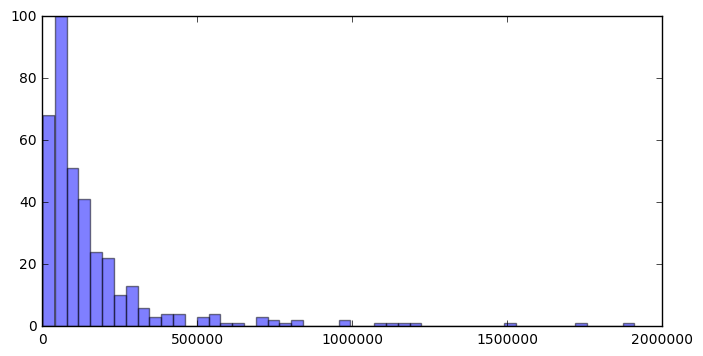

In [405]:
fig = plt.figure(figsize=(8,4))
plt.yscale('linear')
plt.hist(rideship_4['RIDESHIP'], bins=50, alpha = .5)

In [419]:
#del data
#del daily_counts
#del flatten_time_series_data
#del group_1
#del rideship_1
#del rideship_2
#del rideship_3